<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/dgmm_em_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def _e_step(X, pi_d0, pi_c, pi_cc, mu_c, co_c, mu_cc, co_cc):

  n, p = X.shape
  c = pi_cc.shape[0]

  log_pi_d0 = torch.log(torch.tensor(pi_d0))
  log_pi_d1 = torch.log(torch.tensor(1 - pi_d0))
  
  log_pi_c = torch.log(pi_c)
  log_pi_cc = torch.log(pi_cc)

  ### E-step:
  log_post_top0 = torch.zeros(c, n)
  log_post_top1 = torch.zeros(c, c, n)

  for j in range(c):
  
    ll0 = torch.distributions.MultivariateNormal(mu_c[j].float(), co_c[j].float()).log_prob(X.float())
    log_post_top0[j] = log_pi_d0 + log_pi_c[j] + ll0
  
    for k in range(c):
      if torch.isnan(pi_cc[j,k]): #lower triangular nan
        log_post_top1[j,k] = torch.repeat_interleave(torch.tensor(float("-Inf")), n)
      else:
        ll1 = torch.distributions.MultivariateNormal(mu_cc[j,k].float(), co_cc[j,k].float()).log_prob(X.float())
        log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + ll1

  log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
  log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)

  log_post_top1 = log_post_top1.reshape(c * c, n) #reshape
  log_post_bot1 = torch.logsumexp(log_post_top1, 0) #n
  log_post_g = (log_post_top1 - log_post_bot1).T #nxc (rijk)
  
  likelihood_scores = torch.log(torch.exp(log_post_bot0) + torch.exp(log_post_bot1))
  tlls = torch.sum(likelihood_scores)

  #post_d0 = torch.exp(log_post_bot0) / (torch.exp(log_post_bot0) + torch.exp(log_post_bot1) + 1e-6)
  bot = torch.log(torch.exp(log_post_bot0) + torch.exp(log_post_bot1))
  log_post_d0 = log_post_bot0 - bot
  log_post_d1 = log_post_bot1 - bot

  log_post_dz = log_post_d0[:,None] + log_post_z
  log_post_dg = log_post_d1[:,None] + log_post_g

  return tlls, log_post_d0, log_post_z, log_post_g, log_post_dz, log_post_dg

In [2]:
def _estimate_mean_cov_t1(X, r_ij, reg=1e-6):

  n, p = X.shape
  n, c, c = r_ij.shape

  mut = torch.zeros(c, p)
  cot = torch.zeros(c, p, p)

  n_c = torch.sum(r_ij, dim=0) + reg # (c)

  ## update mu_cj and sigma_cj (full)
  for j in range(c):
    
    mut[j] = torch.sum(X.T * r_ij[:,j], 1) / n_c[j]
    
    ke = (X - mut[j])
    cot[j] = (torch.matmul(ke.T * r_ij[:,j], ke) / n_c[j]) + reg * torch.eye(p)

  return n_c, mut, cot

def _estimate_mean_cov_t2(X, r_ijk, reg=1e-6):

  n, p = X.shape
  n, c, c = r_ijk.shape

  mut = torch.zeros(c, c, p)
  cot = torch.zeros(c, c, p, p)

  n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)

  for j in range(c):
    for k in range(c):      
      if not torch.isnan(n_cc[j,k]):
        mut[j,k] = torch.sum(X.T * r_ijk[:,j,k], 1) / n_cc[j,k]
        
        ke = (X - mut[j,k])
        cot[j,k] = (torch.matmul(ke.T * r_ijk[:,j,k], ke) / n_cc[j,k]) + reg * torch.eye(p)
        
  return n_cc, mut, cot

In [3]:
def _estimate_mean_cov_t1v2(X, r_ij, reg=1e-6):

  n, p = X.shape
  n, c = r_ij.shape

  mut = torch.zeros(c, p)
  cot = torch.zeros(c, p, p)

  n_c = torch.sum(r_ij, dim=0) + reg # (c)

  for j in range(c):
    e_n = torch.round(n_c[j])
    if e_n > 0:
      idx = r_ij[:,j].argsort()[-e_n.int():]
      mut[j] = torch.mean(X[idx], 0)
      if e_n > 1:
        cot[j] = torch.tensor(np.cov(X[idx].T))

  return n_c, mut, cot

def _estimate_mean_cov_t2v2(X, r_ijk, reg=1e-6):

  n, p = X.shape
  n, c, c = r_ijk.shape

  mut = torch.zeros(c, c, p)
  cot = torch.zeros(c, c, p, p)

  n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)

  for j in range(c):
    for k in range(c):
      if not torch.isnan(n_cc[j,k]):
        e_n = torch.round(n_cc[j,k])
        idx = r_ijk[:,j,k].argsort()[-e_n.int():]
        mut[j,k] = torch.mean(X[idx], 0)
        if e_n > 1:
          cot[j,k] = torch.tensor(np.cov(X[idx].T))
        else:
          cot[j,k] = reg * torch.eye(p)
  return n_cc, mut, cot

In [4]:
def _m_step(X, log_postd0, log_postdz, log_postdg, reg=1e-6):

  n_obs, n_comp = log_postdz.shape
  n_obs, n_feat = X.shape

  r_i = torch.exp(log_postd0)
  pi_d0 = torch.sum(r_i) / n_obs # one value
  pi_d1 = 1 - pi_d0

  r_ij = torch.exp(log_postdz)
  #n_c, mu_c, co_c = _estimate_mean_cov_t1(X, r_ij)
  n_c, mu_c, co_c = _estimate_mean_cov_t1v2(X, r_ij)
  pi_c = n_c / n_obs # c values

  log_postdg[torch.isinf(log_postdg)] = float('NaN')
  r_ijk = torch.exp(log_postdg).reshape(n_obs, n_comp, n_comp)
  #n_cc, mu_cc, co_cc = _estimate_mean_cov_t2(X, r_ijk)
  n_cc, mu_cc, co_cc = _estimate_mean_cov_t2v2(X, r_ijk)

  pi_cc = n_cc / n_obs  # cxc matrix  

  return pi_d0, n_c, pi_c, mu_c, co_c, n_cc, pi_cc, mu_cc, co_cc

In [5]:
import numpy as np
import torch

N = 1000

init_means = np.array([
    [5, 2],
    [-3, 5],
    [-4, -7]
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]]
])

ms = torch.tensor(init_means)
cs = torch.tensor(init_covariances)

d_ws = torch.tensor([.95, .05])
z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])

n_clusters, n_features = ms.shape

xx = np.zeros((N, n_features+2))

for i in range(N):
  d = np.random.choice(2, size = 1, p = d_ws)[0]
  
  if d == 0:
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    xx[i] = np.append(np.random.multivariate_normal(ms[z], cs[z]), [d, z])
  else:
    g = np.random.choice(6, size = 1, p = g_ws)[0]
    
    if g == 0:
      idx = [0,0]
    elif g == 1:
      idx = [0,1]
    elif g == 2:
      idx = [0,2]
    elif g == 3:
      idx = [1,1]
    elif g == 4:
      idx = [1,2]
    else:
      idx = [2,2]
      
    xx[i] = np.append(np.random.multivariate_normal(ms[idx[0]] + ms[idx[1]], cs[idx[0]] + cs[idx[1]]), (d, g))

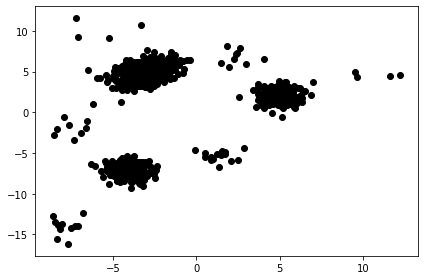

In [6]:
import matplotlib.pyplot as plt
plt.plot(xx[:, 0], xx[:, 1], 'ko')
plt.tight_layout()

In [7]:
c = 3
p = 2
X = torch.tensor(xx[:,:2]).float()

mu_c = torch.tensor([
    [4, 0], #5 2
    [-2, 4], #-3 5
    [-3, -6] #-4 -7
])

co_c = torch.eye(p).reshape((1, p, p)).repeat(c, 1, 1)

mu_cc = torch.zeros(c, c, p)
co_cc = torch.zeros(c, c, p, p)
for j in range(c):
  for k in range(c):
    mu_cc[j,k] = mu_c[j] + mu_c[k]
    co_cc[j,k] = co_c[j] + co_c[k]

pi_c = torch.empty(c).fill_(1. / c)

pi_cc = torch.triu(torch.ones(c, c))
pi_cc = pi_cc / torch.sum(pi_cc)
pi_cc[pi_cc == 0] = float('NaN')

pi_d0 = .9

In [8]:
co_cc

tensor([[[[2., 0.],
          [0., 2.]],

         [[2., 0.],
          [0., 2.]],

         [[2., 0.],
          [0., 2.]]],


        [[[2., 0.],
          [0., 2.]],

         [[2., 0.],
          [0., 2.]],

         [[2., 0.],
          [0., 2.]]],


        [[[2., 0.],
          [0., 2.]],

         [[2., 0.],
          [0., 2.]],

         [[2., 0.],
          [0., 2.]]]])

In [9]:
itermax = 1000
tot = 1e-10

iter = 0
llv = [0.0]
while iter < itermax:
  
  lli, log_pd0, log_pz, log_pg, log_dz, log_dg = _e_step(X, pi_d0, pi_c, pi_cc, mu_c, co_c, mu_cc, co_cc)
  pi_d0, n_c, pi_c, mu_c, co_c, n_cc, pi_cc, mu_cc, co_cc = _m_step(X, log_pd0, log_dz, log_dg)
  
  #def _e_step(X, c, pi_d0, pi_c, pi_cc, mu_c, co_c, mu_cc, co_cc):
  #return tlls, log_post_d0, log_post_z, log_post_g, log_dz, log_dg
  #def _m_step(X, log_postd0, log_postdz, log_postdg, mu_cc, reg=1e-6):
  #return pi_d0, n_c, pi_c, mu_c, co_c, n_cc, pi_cc, mu_cc, co_cc

  print('Iteration', iter + 1, 'Likelihood: ', lli)

  if abs(llv[-1] - lli) < tot:
    break
      
  llv.append(lli)
  iter += 1

  #return llv[1:]

Iteration 1 Likelihood:  tensor(-5187.2788)
Iteration 2 Likelihood:  tensor(-3941.6033)
Iteration 3 Likelihood:  tensor(-3849.2659)
Iteration 4 Likelihood:  tensor(-3831.7979)
Iteration 5 Likelihood:  tensor(-3831.5537)
Iteration 6 Likelihood:  tensor(-3831.5532)
Iteration 7 Likelihood:  tensor(-3831.5535)
Iteration 8 Likelihood:  tensor(-3831.5535)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


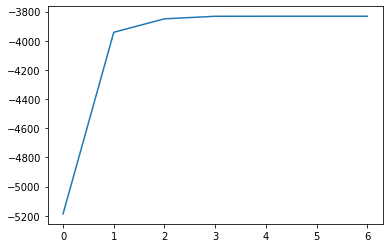

In [10]:
plt.plot(llv[1:])

In [11]:
pi_d0

tensor(0.9481)

In [12]:
mu_c

tensor([[ 5.0028,  1.9794],
        [-2.9669,  4.9884],
        [-4.0507, -7.1032]])

In [13]:
for i in range(c):
  print(torch.mean(torch.tensor(xx[(xx[:,2] == 0) & (xx[:,3] == i),:2]),0))

tensor([5.0028, 1.9794], dtype=torch.float64)
tensor([-2.9719,  4.9854], dtype=torch.float64)
tensor([-4.0507, -7.1032], dtype=torch.float64)


In [14]:
co_c

tensor([[[ 0.4587,  0.0148],
         [ 0.0148,  0.5400]],

        [[ 0.8449,  0.3370],
         [ 0.3370,  0.8499]],

        [[ 0.4742, -0.0489],
         [-0.0489,  0.4978]]])

In [15]:
for i in range(c):
  print(np.cov(np.array(torch.tensor(xx[(xx[:,2] == 0) & (xx[:,3] == i),:2])).T))

[[0.45872908 0.0147731 ]
 [0.0147731  0.53995945]]
[[0.83424763 0.33036126]
 [0.33036126 0.84730018]]
[[ 0.47419382 -0.04894154]
 [-0.04894154  0.49779793]]


In [16]:
mu_cc

tensor([[[ 10.7548,   4.6049],
         [  2.4543,   6.7968],
         [  1.3565,  -5.3480]],

        [[  0.0000,   0.0000],
         [ -5.7304,  10.1890],
         [ -7.3411,  -1.6478]],

        [[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [ -7.8469, -14.0137]]])

In [17]:
for i in range(6):
  print(torch.mean(torch.tensor(xx[(xx[:,2] == 1) & (xx[:,3] == i),:2]),0))

tensor([10.7548,  4.6049], dtype=torch.float64)
tensor([2.1563, 6.7605], dtype=torch.float64)
tensor([ 1.3565, -5.3480], dtype=torch.float64)
tensor([-5.7304, 10.1890], dtype=torch.float64)
tensor([-7.3411, -1.6478], dtype=torch.float64)
tensor([ -7.8469, -14.0137], dtype=torch.float64)


In [18]:
co_cc

tensor([[[[ 1.8978e+00, -6.0867e-02],
          [-6.0867e-02,  9.4419e-02]],

         [[ 5.7420e-01, -2.7205e-02],
          [-2.7205e-02,  7.8345e-01]],

         [[ 6.1278e-01, -1.5761e-03],
          [-1.5761e-03,  3.6001e-01]]],


        [[[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00]],

         [[ 3.3901e+00, -2.5483e-02],
          [-2.5483e-02,  1.4180e+00]],

         [[ 6.8867e-01,  4.8461e-01],
          [ 4.8461e-01,  1.7505e+00]]],


        [[[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00]],

         [[ 3.7357e-01,  8.8071e-02],
          [ 8.8071e-02,  1.2152e+00]]]])

In [19]:
for i in range(6):
  print(np.cov(np.array(torch.tensor(xx[(xx[:,2] == 1) & (xx[:,3] == i),:2])).T))

[[ 1.89782006 -0.06086685]
 [-0.06086685  0.09441858]]
[[1.39815487 0.08383049]
 [0.08383049 0.7095458 ]]
[[ 0.61278157 -0.00157609]
 [-0.00157609  0.36001153]]
[[ 3.39013079 -0.02548374]
 [-0.02548374  1.41796778]]
[[0.68867275 0.48460596]
 [0.48460596 1.75053723]]
[[0.373566   0.08807096]
 [0.08807096 1.21521196]]


In [20]:
pi_c.sum() + torch.triu(pi_cc).sum()

tensor(1.)

In [21]:
torch.triu(n_cc).sum()

tensor(51.8760)

In [22]:
sum(xx[:,2] == 1)

53

In [23]:
n_cc

tensor([[ 4.0001,  8.9848, 15.0000],
        [    nan,  4.0014,  8.8897],
        [    nan,     nan, 11.0000]])

In [24]:
print(sum((xx[:,2] == 1) & (xx[:,3] == 0)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 1)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 2)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 3)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 4)))
print(sum((xx[:,2] == 1) & (xx[:,3] == 5)))

4
10
15
4
9
11


In [25]:
n_c.sum()

tensor(948.1240)

In [26]:
sum(xx[:,2] == 0)

947

In [27]:
n_c

tensor([227.9999, 483.1241, 237.0000])

In [28]:
print(sum((xx[:,2] == 0) & (xx[:,3] == 0)))
print(sum((xx[:,2] == 0) & (xx[:,3] == 1)))
print(sum((xx[:,2] == 0) & (xx[:,3] == 2)))

228
482
237


In [29]:
pred = torch.zeros(N, 2)

dd = torch.exp(log_pd0)
zd = torch.exp(log_dz)
gd = torch.exp(log_dg)

for i in range(N):
  if dd[i] > .5:
    pred[i] = torch.tensor([0, torch.max(zd[i], 0).indices])
  else:
    pred[i] = torch.tensor([1, torch.max(gd[i][~torch.isnan(gd[i])], 0).indices])


#for i in range(n):
#  d1pred[i,:] = torch.tensor(np.unravel_index(r_ijk[:,:,i].argmax(), r_ijk[:,:,i].shape))
#d1pred

In [30]:
sum(pred[:,0] == 0)

tensor(948)

In [31]:
print(sum((pred[:,0] == 1) & (pred[:,1] == 0)))
print(sum((pred[:,0] == 1) & (pred[:,1] == 1)))
print(sum((pred[:,0] == 1) & (pred[:,1] == 2)))
print(sum((pred[:,0] == 1) & (pred[:,1] == 3)))
print(sum((pred[:,0] == 1) & (pred[:,1] == 4)))
print(sum((pred[:,0] == 1) & (pred[:,1] == 5)))

tensor(4)
tensor(9)
tensor(15)
tensor(4)
tensor(9)
tensor(11)
